In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal
from scipy.fftpack import fft
from scipy.signal import (butter, lfilter, spectrogram)
import os
from IPython.display import Audio
from scipy.fftpack import fft, rfft, fftfreq, rfftfreq, irfft

dir_path = './AmazonBird50_training_input/'
sampling_rate = 44100  # Hz

labels = pd.read_csv(
    './challenge_output_data_training_file_classify_bird_songs.csv', sep=";")



In [60]:
def read_wav_iter(dir_path=dir_path, verbose=0):
    for _, _, files in os.walk(dir_path):
        for i, file_name in enumerate(sorted(files)):
            if 'Store' not in file_name:
                if verbose:
                    print(file_name)
                _, data = wavfile.read(dir_path + file_name)
                yield data

data_iter = read_wav_iter(verbose=1)

In [ ]:
import subprocess
def extract_MFCC(dir_path=dir_path, path_to_config='../../Programmes/openSMILE-2.1.0/config/MFCC12_0_D_A.conf', verbose=0):
    for _, _, files in os.walk(dir_path):
        for i, file_name in enumerate(sorted(files)):
            if verbose:
                print(file_name)
            out_file_name = file_name.replace('.wav','.csv')
            line_command = 'SMILExtract -C ' + config + ' -I ' + dir_path + file_name + ' -O ' + 'MFCC_' + out_file_name
            subprocess.call(line_command, shell=True)

In [179]:
sig = data_iter.next()
Audio(sig, rate=sampling_rate)

ID0003.wav


Fonctions pour calculer le spectrogramme en puissance, en amplitude et l'afficher

In [62]:
def spectro_conv(signal, fs):
    f, t, spectro = spectrogram(signal, fs=fs, window=("kaiser", 8.0), nperseg=256, noverlap=64)
    return f, t, spectro


def plot_spectrogram(f, t, spectro):
    plt.figure(figsize=(12,8))
    plt.pcolormesh(t, f, spectro, cmap="jet")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()


def compute_amplitudes(spectro):
    return 20*np.log10(np.abs(spectro))


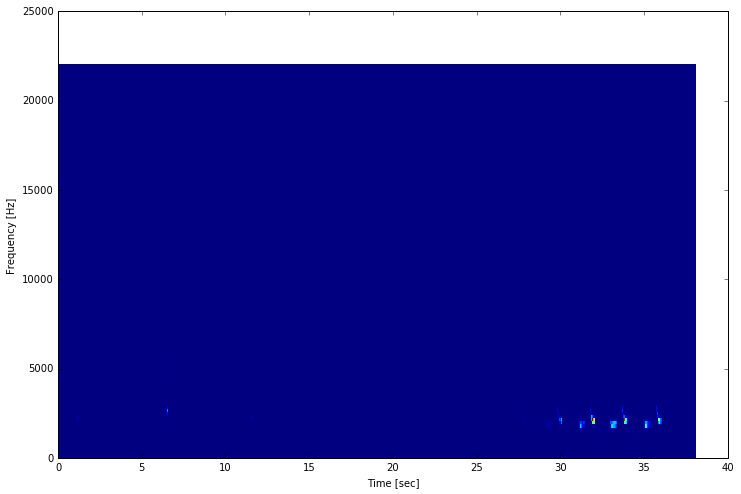

In [180]:
f, t, spectro = spectro_conv(sig, sampling_rate)
plot_spectrogram(f, t, spectro)

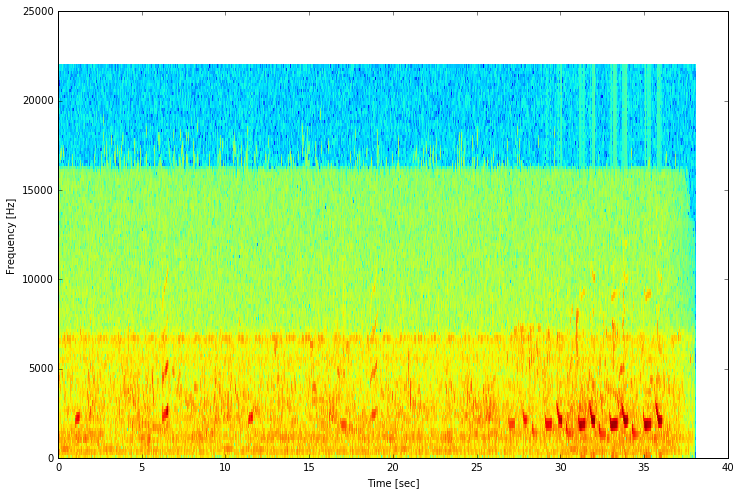

In [181]:
ampli = compute_amplitudes(spectro)
plot_spectrogram(f, t, ampli)

In [131]:
# incertitude : use same frequency to find high cut and low cut or max over all frequencies ???
def extract_syllabe(spectro, beta=20, stop_amp=40, all_freq=True):  # test stop_amp value (proportional to beta)
    # compute amplitudes
    amplitudes = compute_amplitudes(spectro)
    # look for indice of max in spectrogram
    spectro_abs = np.abs(spectro)
    max_power = np.max(spectro_abs)
    max_ampli = 20*math.log(max_power, 10)
    if max_ampli <= stop_amp:
        return -1, -1, -1, -1
    # find index of row and column corresponding to max power/amplitude
    f_max, t_max = np.unravel_index(spectro_abs.argmax(), spectro_abs.shape)
    # browse neighbor amplitudes until it has decreased enough
    # forward search
    high_cut = spectro.shape[1] - 1
    for t in range(spectro.shape[1]):
        if all_freq:
            curr_value = np.max(amplitudes[:, t_max+t])
        else:
            curr_value = amplitudes[f_max, t_max+t]
        if t_max + t >= spectro.shape[1] - 1:
            break
        if curr_value < max_ampli - beta:
            high_cut = t_max + t
            break
    # backward search
    low_cut = 0
    for t in range(spectro.shape[1]):
        if all_freq:
            curr_f_max = np.max(amplitudes[:, t_max-t])
        else:
            curr_value = amplitudes[f_max, t_max-t]
        if t_max - t <= 0:
            break
        if curr_value < max_ampli - beta:
            low_cut = t_max - t
            break
    return low_cut, high_cut, t_max, max_power


def extract_all_syllabes(spectro, beta=30, stop_amp=10, n_max=100, all_freq=True):
    low_cuts = []
    high_cuts = []
    idxs_max = []
    max_powers = []
    spectro_bis = spectro.copy()

    for i in range(n_max):
        low_cut, high_cut, idx_max, max_power = extract_syllabe(spectro_bis, beta=beta, stop_amp=stop_amp, all_freq=all_freq)
        # this means that there are no longer syllabes to extract
        if low_cut == -1:
            break
        low_cuts.append(low_cut)
        high_cuts.append(high_cut)
        idxs_max.append(idx_max)
        max_powers.append(max_power)
        # put values to zero to avoid retrieving same syllabe multiple times
        spectro_bis[:, low_cut:high_cut+1] = np.zeros((spectro_bis.shape[0], high_cut-low_cut+1))

    return low_cuts, high_cuts, idxs_max, max_powers

Des syllabes normales pour un chant d'oiseau durent entre $40$ et $400$ ms.

In [184]:
low, high, idx_max, max_pow= extract_all_syllabes(spectro, beta=70, stop_amp=90, n_max=1000, all_freq=False)
conv_ratio = 192000./44100.
print "%d syllabes extracted" % len(low)
print "Average length : %.2f ms" % (conv_ratio*(np.array(high) - np.array(low))).mean()
print "Min length :  %.2f ms" % np.min(conv_ratio*(np.array(high) - np.array(low)))
print "Max length :  %.2f ms" % np.max(conv_ratio*(np.array(high) - np.array(low)))

21 syllabes extracted
Average length : 271.80 ms
Min length :  52.24 ms
Max length :  487.62 ms


On peut écouter les syllabes extraites pour voir si elles contiennent effectivement les séquences de chant.

In [185]:
def gen_syllabes(sig, low, high):
    for i, idx_low in enumerate(low):
        idx_high = high[i]
        yield sig[idx_low*192:(idx_high+1)*192]

syllabe_gen = gen_syllabes(sig, low, high)

In [199]:
syl = syllabe_gen.next()
Audio(syl, rate=sampling_rate)

In [169]:
def plot_syllabe_boundaries(f, t, high, low, ampli):
    plt.figure(figsize=(12,8))
    plt.pcolormesh(t, f, ampli, cmap="jet")
    for i, idx_low in enumerate(low):
        idx_high = high[i]
        plt.axvline(t[idx_low], color='k')
        plt.axvline(t[idx_high+1], color='k')
        plt.plot([t[idx_low], t[idx_high+1]], [24000, 24000], 'r')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

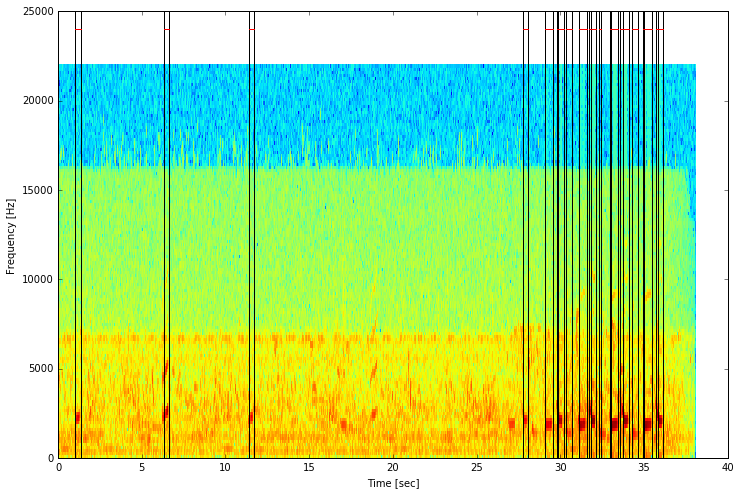

In [183]:
plot_syllabe_boundaries(f, t, high, low, ampli)

In [137]:
ampli
print ampli.shape
print ampli.shape[0]
print ampli.shape[1]

(129, 9991)
129
9991


In [119]:
9991 * 192

1918272

In [120]:
40 * 44100

1764000

In [122]:
22000 / 129

170

In [140]:
np.arg(ampli)

-38.203793

In [141]:
np.unravel_index(ampli.argmax(), ampli.shape)

(19, 736)

In [142]:
ampli[17:22,734:739]

array([[  78.43300629,   73.91664886,   75.53981781,   58.44332886,
          74.71276093],
       [ 112.14488983,  109.9236145 ,  108.90705109,  101.72369385,
          97.89637756],
       [ 121.88236237,  122.10150909,  123.28418732,  121.01059723,
         118.88217926],
       [ 112.17502594,  115.31841278,  119.79312897,  121.39826965,
         122.0120697 ],
       [  76.12228394,   85.53746033,   95.73042297,  101.77177429,
         105.48442841]], dtype=float32)

In [143]:
t[1] - t[0]

0.0043537414965986402

In [144]:
192. / 44100.

0.004353741496598639

In [202]:
def segmentation(sig, fs, beta=70, stop_amp=90, n_max=1000, all_freq=False):
    f, t, spectro = spectro_conv(sig, fs)
    low, high, _, _ = extract_all_syllabes(spectro, beta=beta, stop_amp=stop_amp, n_max=n_max, all_freq=all_freq)
    conv_ratio = 192000./44100.
    print "%d syllabes extracted" % len(low)
    print "Average length : %.2f ms" % (conv_ratio*(np.array(high) - np.array(low))).mean()
    print "Min length :  %.2f ms" % np.min(conv_ratio*(np.array(high) - np.array(low)))
    print "Max length :  %.2f ms" % np.max(conv_ratio*(np.array(high) - np.array(low)))
    syllabe_gen = gen_syllabes(sig, low, high)
    return syllabe_gen

In [203]:
syllabe_iter = segmentation(sig, sampling_rate, beta=70, stop_amp=90, n_max=1000, all_freq=False)

21 syllabes extracted
Average length : 271.80 ms
Min length :  52.24 ms
Max length :  487.62 ms
